In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score

In [157]:
%run rush-win-predictor-2v2-feature-selection-general.ipynb

In [158]:
pro_frames_merge_trunc[features2].dtypes

width_in                 float64
s_in                     float64
s_out                    float64
a_in                     float64
a_out                    float64
squareness_in            float64
squareness_out           float64
open_outside_in          float64
open_outside_out         float64
moving_outside_in        float64
moving_outside_out       float64
rotation_outside_in      float64
rotation_outside_out     float64
x_diff                   float64
y_diff                   float64
dist                     float64
min_qb_dist              float64
rel_rotation             float64
penetrator_depth         float64
mean_qb_squareness       float64
stunt_type              category
exchange                   int64
dtype: object

In [159]:
pro_frames_merge_window = pro_frames_merge_trunc.copy()
features_sw = features2.copy()

In [160]:
for col in features2[:-2]:
    for i in range(1,6):
        col_name = col + '_lag' + str(i)
        features_sw.append(col_name)
        pro_frames_merge_window[col_name] = pro_frames_merge_window.groupby(['gameId', 'playId', 'stuntId'])[col].shift(i)

C:\Users\surma\AppData\Local\Temp\ipykernel_11380\4118373795.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pro_frames_merge_window[col_name] = pro_frames_merge_window.groupby(['gameId', 'playId', 'stuntId'])[col].shift(i)
C:\Users\surma\AppData\Local\Temp\ipykernel_11380\4118373795.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pro_frames_merge_window[col_name] = pro_frames_merge_window.groupby(['gameId', 'playId', 'stuntId'])[col].shift(i)
C:\Users\surma\AppData\Local\Temp\ipykernel_11380\4118373795.py:5: Performance

In [162]:
pro_frames_merge_wtrunc = pro_frames_merge_window[pro_frames_merge_window['frame_from_snap'] > 4]
pro_frames_merge_wtrunc[:50]

,gameId,playId,nflId_in,frameId,week,time,team,x_rel_in,y_rel_in,o_rel_in,...,penetrator_depth_lag1,penetrator_depth_lag2,penetrator_depth_lag3,penetrator_depth_lag4,penetrator_depth_lag5,mean_qb_squareness_lag1,mean_qb_squareness_lag2,mean_qb_squareness_lag3,mean_qb_squareness_lag4,mean_qb_squareness_lag5
5,2021090900,97,46163.0,11,1,2021-09-10T00:26:32.100,TB,1.22,-1.85,12.10,...,-0.12,-0.36,-0.52,-0.62,-0.68,41.592017,40.526851,39.357714,41.264872,41.180545
6,2021090900,97,46163.0,12,1,2021-09-10T00:26:32.200,TB,1.21,-1.95,14.60,...,0.19,-0.12,-0.36,-0.52,-0.62,32.409327,41.592017,40.526851,39.357714,41.264872
7,2021090900,97,46163.0,13,1,2021-09-10T00:26:32.300,TB,1.23,-2.08,17.38,...,0.52,0.19,-0.12,-0.36,-0.52,12.820210,32.409327,41.592017,40.526851,39.357714
8,2021090900,97,46163.0,14,1,2021-09-10T00:26:32.400,TB,1.26,-2.21,20.19,...,0.88,0.52,0.19,-0.12,-0.36,5.868265,12.820210,32.409327,41.592017,40.526851
9,2021090900,97,46163.0,15,1,2021-09-10T00:26:32.500,TB,1.30,-2.37,24.24,...,1.27,0.88,0.52,0.19,-0.12,1.659562,5.868265,12.820210,32.409327,41.592017
10,2021090900,97,46163.0,16,1,2021-09-10T00:26:32.600,TB,1.35,-2.55,29.26,...,1.67,1.27,0.88,0.52,0.19,10.014278,1.659562,5.868265,12.820210,32.409327
11,2021090900,97,46163.0,17,1,2021-09-10T00:26:32.700,TB,1.41,-2.78,35.34,...,2.06,1.67,1.27,0.88,0.52,8.918312,10.014278,1.659562,5.868265,12.820210
12,2021090900,97,46163.0,18,1,2021-09-10T00:26:32.800,TB,1.41,-2.99,36.18,...,2.42,2.06,1.67,1.27,0.88,10.202455,8.918312,10.014278,1.659562,5.868265
13,2021090900,97,46163.0,19,1,2021-09-10T00:26:32.900,TB,1.42,-3.25,23.20,...,2.76,2.42,2.06,1.67,1.27,8.921062,10.202455,8.918312,10.014278,1.659562
14,2021090900,97,46163.0,20,1,2021-09-10T00:26:33.000,TB,1.40,-3.48,21.22,...,3.06,2.76,2.42,2.06,1.67,6.705180,8.921062,10.202455,8.918312,10.014278


In [163]:
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', 
                            seed=123,
                            tree_method = 'approx',
                            eval_metric = 'auc',
                            scale_pos_weight = 2,
                            base_score = 0.33,
                            enable_categorical = True,
                            early_stopping_rounds = 10)
xgbcv = cv_towo(data = pro_frames_merge_wtrunc,
                 features = features_sw,
                 target_col = 'rush_win',
                 num_weeks = num_weeks,
                 classifier = xgb_clf)

In [164]:
xgbcv.run_cv()

In [165]:
xgbcv.get_auc(), xgbcv.get_avg_train_auc(), xgbcv.get_f1()

(0.6532650461838494, 0.8796222593575841, 0.46891043924700515)

In [166]:
xgbcv.get_top_n_features(n=25, return_scores = True)

mean_qb_squareness           0.038181
y_diff                       0.016388
exchange                     0.015943
penetrator_depth_lag5        0.015796
stunt_type                   0.014437
s_out                        0.014223
s_in                         0.014100
x_diff_lag3                  0.013888
penetrator_depth             0.013165
rel_rotation                 0.012972
open_outside_in              0.012148
rotation_outside_out_lag5    0.011392
width_in_lag2                0.011204
moving_outside_out_lag5      0.010988
moving_outside_in_lag3       0.010911
width_in_lag1                0.010879
dist                         0.010857
moving_outside_in_lag4       0.010855
moving_outside_in_lag2       0.010803
x_diff_lag5                  0.010520
rel_rotation_lag5            0.010515
open_outside_in_lag5         0.010098
y_diff_lag1                  0.010012
x_diff_lag1                  0.009923
rel_rotation_lag2            0.009903
dtype: float32

In [167]:
xgbcv.get_scores_by_frame('frame_from_overlap')

,count,pred,prob,f1_score,auc_score
frame_from_overlap,,,,,
-18,36,0.333333,0.433105,0.272727,0.519231
-17,93,0.279570,0.445482,0.363636,0.584052
-16,157,0.324841,0.439675,0.400000,0.584373
-15,232,0.318966,0.444921,0.361111,0.580159
-14,330,0.330303,0.448248,0.359447,0.555973
-13,441,0.349206,0.455977,0.363636,0.530307
-12,569,0.344464,0.457437,0.410127,0.555120
-11,666,0.367868,0.461670,0.399151,0.542443
-10,756,0.363757,0.458738,0.393996,0.548220


In [168]:
pro_frames_merge_wdesc = pro_frames_merge_wtrunc.copy()
features_swd = features2[-2:]
for feature in features2[:-2]:
    feature_cols = [col for col in pro_frames_merge_wdesc.columns if feature in col]
    mean_col = feature + '_avg'
    pro_frames_merge_wdesc[mean_col] = pro_frames_merge_wdesc[feature_cols].mean(axis = 1)
    delta_col = feature + '_delta'
    pro_frames_merge_wdesc[delta_col] = pro_frames_merge_wdesc[feature] - pro_frames_merge_wdesc[feature + '_lag4']
    sd_col = feature + '_sd'
    pro_frames_merge_wdesc[sd_col] = pro_frames_merge_wdesc[feature_cols].std(axis = 1)
    features_swd.extend([mean_col,delta_col,sd_col])

In [169]:
xgbcv_desc = cv_towo(data = pro_frames_merge_wdesc,
                 features = features_swd,
                 target_col = 'rush_win',
                 num_weeks = num_weeks,
                 classifier = xgb_clf)

In [170]:
xgbcv_desc.run_cv()

In [171]:
xgbcv_desc.get_auc(), xgbcv_desc.get_avg_train_auc(), xgbcv_desc.get_f1()

(0.6692369793453953, 0.8805950992012014, 0.48208234191362026)

In [173]:
xgbcv_desc.get_scores_by_frame('frame_from_snap')

,count,pred,prob,f1_score,auc_score
frame_from_snap,,,,,
5,906,0.228477,0.417023,0.277228,0.518829
6,906,0.283664,0.433497,0.317117,0.507710
7,906,0.309051,0.442592,0.352941,0.543839
8,906,0.354305,0.452069,0.368336,0.543646
9,906,0.353201,0.456884,0.398058,0.567465
10,906,0.354305,0.459506,0.423263,0.573263
11,906,0.383002,0.460627,0.431008,0.574620
12,906,0.371965,0.458635,0.437795,0.593126
13,906,0.353201,0.455666,0.440129,0.625041


In [174]:
xgbcv_desc.get_top_n_features(30, return_scores = True)

penetrator_depth_delta        0.049175
mean_qb_squareness_sd         0.045880
mean_qb_squareness_delta      0.041565
s_in_delta                    0.026554
squareness_out_sd             0.026327
exchange                      0.021158
mean_qb_squareness_avg        0.020769
y_diff_delta                  0.020167
rel_rotation_avg              0.020078
penetrator_depth_avg          0.019420
rotation_outside_in_sd        0.018716
open_outside_in_delta         0.018708
stunt_type                    0.018403
y_diff_avg                    0.018200
dist_avg                      0.018014
squareness_in_avg             0.017907
rel_rotation_delta            0.017457
min_qb_dist_delta             0.017175
width_in_delta                0.016686
open_outside_in_avg           0.016684
penetrator_depth_sd           0.016490
x_diff_avg                    0.016413
rotation_outside_out_delta    0.016239
x_diff_delta                  0.015940
moving_outside_in_avg         0.015695
s_out_delta              

In [58]:
# Forward selection
xgbcv_desc.set_features(features_swd)
fw_feat_sel = feature_selector(xgbcv_desc)
fw_feat_sel.sw_select_cust(start_features = [], fw_select_type = 'all', bw_select_type = 'none')

Testing features: ['a_in_avg']
Test score = 0.4783
Testing features: ['a_in_delta']
Test score = 0.4668
Testing features: ['a_in_sd']
Test score = 0.5204
Testing features: ['a_out_avg']
Test score = 0.4658
Testing features: ['a_out_delta']
Test score = 0.4850
Testing features: ['a_out_sd']
Test score = 0.5344
Testing features: ['dist_avg']
Test score = 0.4942
Testing features: ['dist_delta']
Test score = 0.4911
Testing features: ['dist_sd']
Test score = 0.5118
Testing features: ['exchange']
Test score = 0.5073
Testing features: ['mean_qb_squareness_avg']
Test score = 0.5406
Testing features: ['mean_qb_squareness_delta']
Test score = 0.5681
Testing features: ['mean_qb_squareness_sd']
Test score = 0.5812
Testing features: ['min_qb_dist_avg']
Test score = 0.5314
Testing features: ['min_qb_dist_delta']
Test score = 0.5414
Testing features: ['min_qb_dist_sd']
Test score = 0.5151
Testing features: ['moving_outside_in_avg']
Test score = 0.4853
Testing features: ['moving_outside_in_delta']
Tes

Test score = 0.6220
Testing features: ['penetrator_depth_sd', 'x_diff_avg']
Test score = 0.6135
Testing features: ['penetrator_depth_sd', 'x_diff_delta']
Test score = 0.6399
Testing features: ['penetrator_depth_sd', 'x_diff_sd']
Test score = 0.6305
Testing features: ['penetrator_depth_sd', 'y_diff_avg']
Test score = 0.6229
Testing features: ['penetrator_depth_sd', 'y_diff_delta']
Test score = 0.6087
Testing features: ['penetrator_depth_sd', 'y_diff_sd']
Test score = 0.6316
Adding feature mean_qb_squareness_sd
New max auc: 0.6562
Fitting to features {'penetrator_depth_sd', 'mean_qb_squareness_sd'}
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd', 'a_in_avg']
Test score = 0.6525
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd', 'a_in_delta']
Test score = 0.6518
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd', 'a_in_sd']
Test score = 0.6566
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd', 'a_out_avg']
Test score = 0.652

Test score = 0.6657
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'mean_qb_squareness_sd', 'mean_qb_squareness_avg']
Test score = 0.6658
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'mean_qb_squareness_sd', 'mean_qb_squareness_delta']
Test score = 0.6671
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'mean_qb_squareness_sd', 'min_qb_dist_avg']
Test score = 0.6569
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'mean_qb_squareness_sd', 'min_qb_dist_delta']
Test score = 0.6729
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'mean_qb_squareness_sd', 'min_qb_dist_sd']
Test score = 0.6743
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg']
Test score = 0.6652
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'mean_qb_squareness_sd', 'moving_outside_in_delta']
Test score = 0.6657
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'mean_qb_squareness_s

Test score = 0.6718
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'min_qb_dist_delta']
Test score = 0.6718
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'min_qb_dist_sd']
Test score = 0.6572
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg']
Test score = 0.6692
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_in_delta']
Test score = 0.6619
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_in_sd']
Test score = 0.6730
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg']
Test score = 0.6800
Testing features: ['penetrator_depth_sd', 'width_in_delta', 'pene

Test score = 0.6796
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'dist_sd']
Test score = 0.6825
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6843
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'mean_qb_squareness_avg']
Test score = 0.6755
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta']
Test score = 0.6816
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'min_qb_dist_avg']
Test score = 0.6795
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'min_qb_di

Test score = 0.6756
Adding feature open_outside_in_avg
New max auc: 0.6871
Fitting to features {'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg'}
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'a_in_avg']
Test score = 0.6787
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'a_in_delta']
Test score = 0.6763
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'a_in_sd']
Test score = 0.6837
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'a_out_avg']
Test score = 0.6806
Testing features: ['width_in_delt

Test score = 0.6821
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'squareness_in_delta']
Test score = 0.6796
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'squareness_in_sd']
Test score = 0.6820
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'squareness_out_avg']
Test score = 0.6827
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'squareness_out_delta']
Test score = 0.6787
Testing features: ['width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'squareness_out_sd']
Test score = 0.6881
Testing fe

Test score = 0.6797
Testing features: ['x_diff_avg', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'penetrator_depth_delta']
Test score = 0.6805
Testing features: ['x_diff_avg', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'rel_rotation_delta']
Test score = 0.6827
Testing features: ['x_diff_avg', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'rel_rotation_sd']
Test score = 0.6807
Testing features: ['x_diff_avg', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'open_outside_in_avg', 'rotation_outside_in_avg']
Test score = 0.6770
Testing features: ['x_diff_avg', 'width_in_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'rel_rotation_avg', 'penetrator_depth_sd',

In [59]:
fw_feat_sel.best_score

0.6889867754979317

In [60]:
fw_feat_sel.best_features

{'mean_qb_squareness_sd',
 'open_outside_in_avg',
 'penetrator_depth_avg',
 'penetrator_depth_sd',
 'rel_rotation_avg',
 'width_in_delta',
 'x_diff_avg'}

In [62]:
# Backward selection
xgbcv_desc.set_features(features_swd)
bw_feat_sel = feature_selector(xgbcv_desc)
bw_feat_sel.sw_select_cust(start_features = features_swd, fw_select_type = 'none', bw_select_type = 'all')

Initial model auc score: 0.6756
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_d

Test score = 0.6641
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_

Test score = 0.6689
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delt

Test score = 0.6710
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 

Test score = 0.6670
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta',

Test score = 0.6721
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'width_in_delta', 'mea

Test score = 0.6722
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'wid

Test score = 0.6709
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta

Test score = 0.6780
Testing features: ['a_out_delta', 'open_outside_out_sd', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 's_out_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_

Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squareness_

Test score = 0.6604
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'm

Test score = 0.6764
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_

Test score = 0.6774
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squa

Test score = 0.6765
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squ

Test score = 0.6750
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'width_in_delta', 'mean_qb_squarene

Test score = 0.6702
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta',

Test score = 0.6711
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squ

Test score = 0.6702
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'a_in_delta', 'stunt_type', 'a_out_avg', 'rotation_outside_out_delta', 's_out_delta', 'mean_qb_squareness_avg', 'y_diff_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mea

Test score = 0.6693
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'm

Test score = 0.6630
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squar

Test score = 0.6707
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squareness_delta',

Test score = 0.6715
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'm

Test score = 0.6690
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squareness_delta

Test score = 0.6718
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squareness_delta', 'o

Test score = 0.6697
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squar

Test score = 0.6761
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squaren

Test score = 0.6709
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squaren

Test score = 0.6755
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squarene

Test score = 0.6811
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'o

Test score = 0.6822
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'm

Test score = 0.6737
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squareness_delta'

Test score = 0.6684
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squareness_delt

Test score = 0.6771
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squareness_delta', '

Test score = 0.6712
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squareness_de

Test score = 0.6759
Testing features: ['a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_out_sd', 'rotation_outside_in_delta', 'width_in_delta', 'mean_qb_squarene

Test score = 0.6753
Failed to drop one of 59 candidates
NO FEATURES DROPPED
Fitting to features {'a_out_delta', 'open_outside_out_sd', 'x_diff_avg', 'dist_sd', 'width_in_sd', 'dist_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'a_out_avg', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'open_outside_out_delta', 'moving_outside_in_avg', 'mean_qb_squareness_sd', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 's_in_sd', 'open_outside_in_avg', 's_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'moving_outside_out_sd', 'a_out_sd', 'penetrator_depth_sd', 'squareness_out_delta', 'penetrator_depth_delta', 'rotation_outside_out_sd', 's_

In [63]:
bw_feat_sel.best_score

0.6838488824668432

In [72]:
bw_feat_sel.best_features

59

In [74]:
xgbcv_desc.set_features(features_swd)
xgbcv_desc.run_cv()

In [76]:
xgbcv_desc.get_top_n_features(50, return_scores = True)

penetrator_depth_sd           0.068145
mean_qb_squareness_sd         0.044672
mean_qb_squareness_delta      0.038251
s_in_delta                    0.025545
mean_qb_squareness_avg        0.024972
penetrator_depth_delta        0.024348
squareness_out_sd             0.020754
y_diff_delta                  0.019681
exchange                      0.019458
y_diff_avg                    0.018911
penetrator_depth_avg          0.018509
rotation_outside_in_sd        0.018402
open_outside_in_avg           0.017714
moving_outside_in_avg         0.017284
dist_avg                      0.017262
rel_rotation_delta            0.017191
min_qb_dist_delta             0.017160
rotation_outside_out_delta    0.017130
rel_rotation_avg              0.017046
open_outside_in_delta         0.016922
squareness_out_avg            0.016112
stunt_type                    0.016076
s_out_delta                   0.015383
rotation_outside_in_avg       0.015319
width_in_avg                  0.015088
squareness_in_avg        

In [124]:
corr_matrix_new = pro_frames_merge_wdesc[features_swd+['rush_win']].corr()
win_corr_new = corr_matrix_new['rush_win'][:-1]
win_corr_new.abs().sort_values(ascending = False)[:50]
#corr_matrix_new['mean_qb_squareness_avg'].abs().sort_values(ascending = False)[:50]

penetrator_depth_sd           0.231819
penetrator_depth_delta        0.230019
mean_qb_squareness_sd         0.189992
squareness_out_sd             0.167367
mean_qb_squareness_avg        0.166315
s_out_sd                      0.158660
mean_qb_squareness_delta      0.157708
s_out_avg                     0.143369
squareness_out_avg            0.141155
squareness_in_sd              0.140957
s_in_sd                       0.133420
s_in_avg                      0.125701
squareness_in_avg             0.124821
rotation_outside_in_sd        0.124592
rotation_outside_out_sd       0.122879
squareness_in_delta           0.117865
rel_rotation_sd               0.110977
rotation_outside_out_delta    0.108017
y_diff_avg                    0.107992
open_outside_out_sd           0.103369
penetrator_depth_avg          0.102899
y_diff_sd                     0.100782
exchange                      0.096738
x_diff_sd                     0.094788
squareness_out_delta          0.089158
open_outside_in_sd       

In [112]:
corr_sets_new = get_multicollinear_sets(pro_frames_merge_wdesc,features_swd)

In [136]:
chosen_features = ['mean_qb_squareness_avg',
                   'squareness_out_avg',
                   'penetrator_depth_sd',
                   'min_qb_dist_avg',
                   'moving_outside_in_avg',                 
]
remaining_sets, features_swd2 = remove_multicollinear_features(features_swd, corr_sets_new, chosen_features)
remaining_sets

[]

In [137]:
xgbcv_desc.set_features(features_swd2)
xgbcv_desc.run_cv()

In [138]:
xgbcv_desc.get_auc(), xgbcv_desc.get_avg_train_auc(), xgbcv_desc.get_f1()

(0.6746793490327395, 0.893189527738099, 0.5023418385180006)

In [139]:
#'Custom' step-wise selection. Tests starting with n pre-selected features
n_info = []
xgbcv_desc.set_features(features_swd2)
xgbcv_desc.run_cv()
xgbcv_test = cv_towo(data = pro_frames_merge_wdesc,
                 features = features_swd2,
                 target_col = 'rush_win',
                 num_weeks = num_weeks,
                 classifier = xgb_clf)
for n in range(0,41):
    xgbcv_test.set_features(features_swd2)
    start_features = xgbcv_desc.get_top_n_features(n=n)
    sw_feat_sel = feature_selector(xgbcv_test)
    sw_feat_sel.sw_select_cust(win_corr = win_corr_new,
                               start_features = start_features)
    print(f'For n = {n} starting features, best score = {sw_feat_sel.best_score:0.4f} with features', 
          sw_feat_sel.best_features)
    n_info.append((sw_feat_sel.best_score, sw_feat_sel.best_features, xgbcv_test.get_feature_importances_df()))

Testing features: ['penetrator_depth_sd']
Test score = 0.6347
Testing features: ['mean_qb_squareness_sd']
Test score = 0.5812
Testing features: ['squareness_out_sd']
Test score = 0.5672
Adding feature penetrator_depth_sd
New max auc: 0.6347
Fitting to features {'penetrator_depth_sd'}
No features to drop
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd']
Test score = 0.6562
Testing features: ['penetrator_depth_sd', 'squareness_out_sd']
Test score = 0.6430
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_avg']
Test score = 0.6375
Adding feature mean_qb_squareness_sd
New max auc: 0.6562
Fitting to features {'penetrator_depth_sd', 'mean_qb_squareness_sd'}
No features to drop
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd', 'squareness_out_sd']
Test score = 0.6559
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd', 'mean_qb_squareness_avg']
Test score = 0.6499
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd', 'me

Test score = 0.6691
Testing features: ['penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd']
Test score = 0.6186
Failed to drop one of 3 candidates
NO FEATURES DROPPED
Fitting to features {'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd'}
Testing features: ['penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd', 'squareness_out_sd']
Test score = 0.6679
Testing features: ['penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd', 'mean_qb_squareness_avg']
Test score = 0.6627
Testing features: ['penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd', 'mea

Test score = 0.6685
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'y_diff_sd']
Test score = 0.6789
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6741
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'x_diff_sd']
Test score = 0.6681
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'squareness_out_delta']
Test sco

Test score = 0.6686
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta']
Test score = 0.6798
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'squareness_out_avg']
Test score = 0.6790
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd']
Test score = 0.6838
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'mean_qb_sq

Test score = 0.6775
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_out_avg']
Test score = 0.6818
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_out_avg']
Test score = 0.6787
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_out_delta']
Test score = 0.6828
Testing features: ['squareness_in_delta'

Test score = 0.6748
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'min_qb_dist_sd']
Test score = 0.6813
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'width_in_avg']
Test score = 0.6776
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rel_rotation_avg']
Test score = 0.6771
F

Test score = 0.6829
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'moving_outside_in_delta']
Test score = 0.6785
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'a_in_delta']
Test score = 0.6821
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'moving_outside_in_sd']
Test score

Test score = 0.6571
Testing features: ['squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd', 'mean_qb_squareness_avg']
Test score = 0.6540
Testing features: ['squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd', 'mean_qb_squareness_delta']
Test score = 0.6535
Failed to add one of 3 candidates
Testing features: ['squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd', 'squareness_out_avg']
Test score = 0.6610
Testing features: ['squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd', 'rotation_outside_out_sd']
Test score = 0.6522
Testing features: ['squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'penetrator_depth_sd', 'squareness_in_delta']
Test score = 0.6531
Faile

Test score = 0.6651
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd']
Test score = 0.6642
Failed to drop one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd']
Test score = 0.6646
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg']
Test score = 0.6442
Failed to drop one of 2 candidates
NO FEATURES DROPPED
Fitting to features {'squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd'}
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mea

Test score = 0.6827
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'moving_outside_out_delta']
Test score = 0.6785
Adding feature open_outside_in_delta
New max auc: 0.6827
Fitting to features {'squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd'}
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd']
Test score = 0.6785
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'y_diff_avg', 'penetrator_depth_sd']
Test sco

Test score = 0.6808
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'exchange']
Test score = 0.6799
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'x_diff_sd']
Test score = 0.6732
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'squareness_out_delta']
Test score = 0.6772
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'op

Test score = 0.6802
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rel_rotation_sd']
Test score = 0.6740
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_out_sd']
Test score = 0.6816
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'y_diff_sd']
Test score = 0.6818


Test score = 0.6785
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'a_in_avg']
Test score = 0.6814
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'moving_outside_out_sd']
Test score = 0.6820
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'x_diff_avg']
Test score = 0.6806
Fail

Testing features: ['penetrator_depth_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'mean_qb_squareness_sd', 'squareness_out_sd']
Test score = 0.6577
Testing features: ['penetrator_depth_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'mean_qb_squareness_sd', 'mean_qb_squareness_avg']
Test score = 0.6567
Testing features: ['penetrator_depth_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'mean_qb_squareness_sd', 'mean_qb_squareness_delta']
Test score = 0.6579
Failed to add one of 3 candidates
Testing features: ['penetrator_depth_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'mean_qb_squareness_sd', 'squareness_out_avg']
Test score = 0.6540
Testing features: ['penetrator_depth_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'mean_qb_squareness_sd', 'squareness_in_sd']
Test score = 0.6615
Testing features: ['penetrator_depth_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'mean_qb_squareness_sd', 'rotation_o

Test score = 0.6659
Testing features: ['penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'mean_qb_squareness_avg']
Test score = 0.6669
Testing features: ['penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta']
Test score = 0.6761
Failed to add one of 3 candidates
Testing features: ['penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'squareness_out_avg']
Test score = 0.6684
Testing features: ['penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd']
Test score = 0.6693
Testing features: ['penetrator_depth_av

Test score = 0.6730
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'dist_delta']
Test score = 0.6682
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'x_diff_delta']
Test score = 0.6751
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 's_out_delta']
Test score = 0.6710
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'y_diff_delta']
Test scor

Test score = 0.6829
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_avg']
Test score = 0.6771
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta']
Test score = 0.6785
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'squareness_out_avg']
Test score = 0.6731
Testing features: ['squareness_in_delta', 

Test score = 0.6696
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'rotation_outside_out_sd']
Test score = 0.6546
Failed to drop one of 2 candidates
NO FEATURES DROPPED
Fitting to features {'squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd'}
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'squareness_out_sd']
Test score = 0.6844
Testing features: ['squareness_in_delta', 'penetrator_

Test score = 0.6847
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'width_in_sd']
Test score = 0.6781
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'min_qb_dist_avg']
Test score = 0.6756
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'y_diff_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'moving_outside_out_delta']
Test score = 

Test score = 0.6585
Testing features: ['squareness_out_sd', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'squareness_in_sd']
Test score = 0.6597
Adding feature squareness_in_sd
New max auc: 0.6597
Fitting to features {'mean_qb_squareness_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd'}
Testing features: ['squareness_in_sd', 'mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd']
Test score = 0.6644
Testing features: ['mean_qb_squareness_delta', 'squareness_in_sd', 'squareness_out_sd', 'penetrator_depth_sd']
Test score = 0.6619
Testing features: ['mean_qb_squareness_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'squareness_out_sd']
Test score = 0.6045
Dropping feature mean_qb_squareness_delta
New max auc: 0.6644
Fitting to features {'penetrator_depth_sd', 'mean_qb_squareness_sd', 'squareness_out_sd', 'squareness_in_sd'}
Testing features: ['penetrator_depth_sd', 'mean_qb_squareness_sd', 'sq

Test score = 0.6614
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 'penetrator_depth_sd', 'rotation_outside_out_delta']
Test score = 0.6752
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 'penetrator_depth_sd', 'y_diff_avg']
Test score = 0.6611
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 'penetrator_depth_sd', 'open_outside_out_sd']
Test score = 0.6737
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 'penetrator_depth_sd', 'y_diff_sd']
Test score = 0.6744
Failed to add one of 3 candidates
Testing features: ['squarene

Test score = 0.6723
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'rotation_outside_out_delta']
Test score = 0.6770
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'y_diff_avg']
Test score = 0.6725
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'open_outside_out_sd']
Test score = 0.6718
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 'penetrator_depth_sd', 'exchange', 'y_diff_

Test score = 0.6773
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 's_out_delta', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'rotation_outside_out_delta']
Test score = 0.6728
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 's_out_delta', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'y_diff_avg']
Test score = 0.6689
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 's_out_delta', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'open_outside_out_sd']
Test score = 0.6663
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd'

Test score = 0.6696
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 's_out_delta', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'rel_rotation_delta']
Test score = 0.6752
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 's_out_delta', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'open_outside_in_avg']
Test score = 0.6803
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_in_sd', 'squareness_out_sd', 's_out_delta', 'penetrator_depth_sd', 'exchange', 'y_diff_sd', 'moving_outside_in_delta']
Test score = 0.6788
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotat

Test score = 0.6645
Testing features: ['mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'exchange']
Test score = 0.6679
Failed to add one of 3 candidates
Testing features: ['mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'x_diff_sd']
Test score = 0.6721
Testing features: ['mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'squareness_out_delta']
Test score = 0.6431
Testing features: ['mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'open_outside_in_sd']
Test score = 0.6719
Failed to add one of 3 candidates
Testing features: ['mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'stunt_type']
Test score = 0.6627
Testing features: ['mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'min_qb_dist_sd']
Test score = 0.6674

Test score = 0.6392
Failed to drop one of 1 candidates
NO FEATURES DROPPED
Fitting to features {'y_diff_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd'}
Testing features: ['y_diff_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'mean_qb_squareness_avg']
Test score = 0.6733
Testing features: ['y_diff_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'mean_qb_squareness_delta']
Test score = 0.6795
Testing features: ['y_diff_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'y_diff_sd', 'squareness_out_avg']
Test score = 0.6712
Adding feature mean_qb_squareness_delta
New max auc: 0.6795
Fitting to features {'y_diff_delta', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotatio

Test score = 0.6551
Failed to drop one of 3 candidates
NO FEATURES DROPPED
Fitting to features {'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta'}
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'mean_qb_squareness_avg']
Test score = 0.6842
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'squareness_in_sd']
Test score = 0.6823
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_

Test score = 0.6836
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'open_outside_in_sd']
Test score = 0.6816
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'stunt_type']
Test score = 0.6872
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 's_in_delta', 'min_qb_dist_sd']
Test score = 0.6851
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_out_avg

Test score = 0.6792
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta']
Test score = 0.6883
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'rel_rotation_delta']
Test score = 0.6844
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta']
Test score = 0.6854
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'rotation_o

Test score = 0.6792
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta', 'dist_delta']
Test score = 0.6873
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta', 'x_diff_delta']
Test score = 0.6898
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta', 's_out_delta']
Test score = 0.6841
Failed to add one of 3 candidates
Testing feature

Testing features: ['mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd']
Test score = 0.6605
Testing features: ['mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6630
Testing features: ['mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6568
Failed to drop one of 3 candidates
Testing features: ['mean_qb_squareness_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6697
Testing features: ['mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 's_in_delta']
Test score = 0.6322
Dropping feature mean_qb_squareness_sd
New max auc: 0.6697
Fitting to features {'mean_qb_squareness_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Testing f

Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'dist_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd']
Test score = 0.6601
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'dist_delta', 'squareness_out_sd', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6611
Testing features: ['squareness_in_delta', 'dist_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6543
Failed to drop one of 3 candidates
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'dist_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 's_in_delta']
Test score = 0.6344
Failed to drop one of 1 candidates
NO FEATURES DROPPED
Fitting to features {'squareness_in_delta', 'mean_qb_squareness_delta', 'dist_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'dist_del

Test score = 0.6783
Adding feature exchange
New max auc: 0.6783
Fitting to features {'squareness_in_delta', 'mean_qb_squareness_delta', 'exchange', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6694
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'exchange', 'dist_delta', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6621
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'exchange', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd']
Test score = 0.6644
Failed to drop one of 3 candidates
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'exchange', 'dist_delta', 'stunt_type', 's

Test score = 0.6638
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'width_in_avg']
Test score = 0.6685
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'rel_rotation_avg']
Test score = 0.6752
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'open_outside_out_avg']
Test score = 0.6680
Testing features: ['squareness_in_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'pene

Test score = 0.6832
Testing features: ['squareness_in_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'exchange']
Test score = 0.6737
Testing features: ['squareness_in_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'exchange']
Test score = 0.6732
Failed to drop one of 3 candidates
Testing features: ['squareness_in_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'exchange']
Test score = 0.6812
Testing features: ['squareness_in_delta', 'y_diff_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', '

Test score = 0.6856
Testing features: ['squareness_in_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'exchange', 'width_in_sd']
Test score = 0.6790
Testing features: ['squareness_in_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'exchange', 'min_qb_dist_avg']
Test score = 0.6747
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'dist_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'exchange', 'open_outside_in_delta']
Test score = 0.6831
Testing features: ['squareness_in_delta', 'y_diff_delta'

Test score = 0.6693
Testing features: ['mean_qb_squareness_delta', 's_in_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6682
Testing features: ['mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'exchange']
Test score = 0.6441
Failed to drop one of 3 candidates
NO FEATURES DROPPED
Fitting to features {'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange'}
Testing features: ['mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'squareness_out_avg']
Test score = 0.6713
Testing features: ['mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'squareness_in_sd']
Test score = 0.6717
Testing f

Test score = 0.6694
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'squareness_in_sd']
Test score = 0.6780
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'rotation_outside_in_sd']
Test score = 0.6761
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'rotation_outside_out_sd']
Test score = 0.6776
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'squareness_in_delta']
Test score = 0.6810
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'e

Test score = 0.6776
Testing features: ['squareness_in_delta', 'y_diff_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'rel_rotation_sd']
Test score = 0.6818
Testing features: ['squareness_in_delta', 'y_diff_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'rotation_outside_out_delta']
Test score = 0.6713
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'y_diff_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'y_diff_avg']
Test score = 0.6726
Testing features: ['squareness_in_delta', 'y_diff_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'open_outside_out_sd']
Test score = 0.6804
Testing features: ['squareness_in_delta', 'y_diff_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'me

Test score = 0.6819
Testing features: ['squareness_in_delta', 'y_diff_delta', 'moving_outside_out_delta', 's_in_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'rotation_outside_out_sd']
Test score = 0.6751
Testing features: ['squareness_in_delta', 'y_diff_delta', 'moving_outside_out_delta', 's_in_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'rel_rotation_sd']
Test score = 0.6877
Adding feature rel_rotation_sd
New max auc: 0.6877
Fitting to features {'squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'moving_outside_out_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Testing features: ['y_diff_delta', 'rel_rotation_sd', 'moving_outside_out_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6769
Testing features: ['sq

Test score = 0.6817
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'moving_outside_out_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'dist_delta']
Test score = 0.6863
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'moving_outside_out_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'x_diff_delta']
Test score = 0.6771
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'moving_outside_out_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 's_out_delta']
Test score = 0.6814
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'moving_outside_out_delta', 'exchange', 'stunt_type', 'squareness_out_sd', 'mean_qb_s

Test score = 0.6789
Dropping feature mean_qb_squareness_delta
New max auc: 0.6808
Fitting to features {'y_diff_delta', 'mean_qb_squareness_sd', 'exchange', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Testing features: ['y_diff_delta', 'mean_qb_squareness_sd', 'exchange', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'squareness_out_avg']
Test score = 0.6694
Testing features: ['y_diff_delta', 'mean_qb_squareness_sd', 'exchange', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'squareness_in_sd']
Test score = 0.6758
Testing features: ['y_diff_delta', 'mean_qb_squareness_sd', 'exchange', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'rotation_outside_in_sd']
Test score = 0.6784
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_sd', 'exchange', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator

Test score = 0.6749
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'open_outside_out_delta']
Test score = 0.6831
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'rotation_outside_in_avg']
Test score = 0.6804
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'min_qb_dist_delta']
Test score = 0.6785
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'dist_delta']
Test score = 0.6756
Testing features: ['y_diff_delta',

Test score = 0.6735
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6587
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'penetrator_depth_sd', 'exchange']
Test score = 0.6744
Testing features: ['y_diff_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6783
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6776
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_i

Test score = 0.6835
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'open_outside_out_sd']
Test score = 0.6829
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'penetrator_depth_avg']
Test score = 0.6875
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'y_diff_sd']
Test score = 0.6813
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'x_diff_sd']
Test score = 0.6803
T

Test score = 0.6814
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'moving_outside_in_sd']
Test score = 0.6844
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'moving_outside_out_avg']
Test score = 0.6834
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'a_out_delta']
Test score = 0.6855
Failed to add one of 1 candidates
NO FEATURES ADDED
Fitting to features {'y_diff_delta', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrato

Test score = 0.6696
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6749
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6836
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6849
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', '

Test score = 0.6752
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'rel_rotation_sd']
Test score = 0.6787
Testing features: ['squareness_in_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'y_diff_avg']
Test score = 0.6822
Testing features: ['squareness_in_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'open_outside_out_sd']
Test sc

Test score = 0.6798
Testing features: ['squareness_in_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'a_in_sd']
Test score = 0.6827
Testing features: ['squareness_in_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'a_in_avg']
Test score = 0.6758
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'moving_outside_out_sd']
Test score = 0.

Testing features: ['y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'squareness_out_sd']
Test score = 0.6810
Testing features: ['y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'squareness_out_avg']
Test score = 0.6736
Testing features: ['y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'squareness_in_sd']
Test score = 0.6763
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'exchange', 'rot

Test score = 0.6786
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'a_in_avg']
Test score = 0.6769
Testing features: ['y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'moving_outside_out_sd']
Test score = 0.6806
Testing features: ['y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'x_diff_avg']
Test score = 0.6775
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg',

Test score = 0.6796
Adding feature squareness_in_delta
New max auc: 0.6905
Fitting to features {'squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6824
Testing features: ['squareness_in_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6756
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean

Test score = 0.6857
Failed to add one of 3 candidates
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'rotation_outside_out_avg']
Test score = 0.6787
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'open_outside_out_delta']
Test score = 0.6853
Testing features: ['squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'rotation

Test score = 0.6861
Failed to add one of 1 candidates
NO FEATURES ADDED
Fitting to features {'squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Best score auc: 0.6905 with features {'squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
For n = 10 starting features, best score = 0.6905 with features {'squareness_in_delta', 'y_diff_delta', 'rel_rotation_sd', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'exchange', 'rotation_outside_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Initial model auc 

Test score = 0.6855
Failed to drop one of 3 candidates
Testing features: ['penetrator_depth_avg', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6753
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6863
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6871
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg',

Test score = 0.6837
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'dist_delta']
Test score = 0.6842
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'x_diff_delta']
Test score = 0.6852
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 's_out_delta']
Tes

Test score = 0.6790
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6934
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6817
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'penetrator_depth_sd', 's_in_delta']
Test score = 0.6888
Dropping feature re

Test score = 0.6920
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'width_in_sd']
Test score = 0.6893
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'min_qb_dist_avg']
Test score = 0.6805
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delt

Test score = 0.6900
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'a_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'rel_rotation_sd']
Test score = 0.6880
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'a_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'y_diff_avg']
Test score = 0.6835
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'a_in_sd', 'mean_qb_squareness_avg', '

Test score = 0.6932
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'a_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'a_in_avg']
Test score = 0.6841
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'a_in_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'moving_outside_out_sd']
Test score = 0.6872
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'mean_qb_squareness_sd', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'a_in_sd', 'mean_qb_squareness_avg

Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'squareness_out_avg']
Test score = 0.6838
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'rotation_outside_out_sd']
Test score = 0.6790
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'squareness_in_delta']
Test score = 0.6841
Failed to add on

Test score = 0.6829
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'moving_outside_in_avg']
Test score = 0.6812
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'a_out_avg']
Test score = 0.6815
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'a_in_sd']
Test 

Test score = 0.6848
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 's_in_delta']
Test score = 0.6595
Failed to drop one of 2 candidates
NO FEATURES DROPPED
Fitting to features {'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
Best score auc: 0.6883 with features {'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta'}
For n = 12 starting features, best score = 0.6883 with 

Test score = 0.6818
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6794
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6834
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penet

Test score = 0.6883
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'open_outside_out_avg']
Test score = 0.6772
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'open_outside_out_delta']
Test score = 0.6838
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in

Test score = 0.6833
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'a_in_delta']
Test score = 0.6877
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'moving_outside_in_sd']
Test score = 0.6830
Testing features: ['y_diff_delta', 'rotation_outside_out_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squar

Test score = 0.6797
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'open_outside_in_sd']
Test score = 0.6809
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'min_qb_dist_sd']
Test score = 0.6870
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_sq

Test score = 0.6920
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6906
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6845
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', '

Test score = 0.6858
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'dist_delta']
Test score = 0.6869
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'x_diff_delta']
Test score = 0.6882
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'squareness_in_sd', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type',

Test score = 0.6820
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta']
Test score = 0.6888
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta']
Test score = 0.6734
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y

Test score = 0.6825
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta', 'rotation_outside_out_avg']
Test score = 0.6891
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta', 'open_outside_out_delta']
Test score = 0.6861
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squar

Test score = 0.6893
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta', 'moving_outside_in_sd']
Test score = 0.6846
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'rel_rotation_avg', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'rel_rotation_delta', 's_in_delta', 'moving_outside_out_avg']
Test score = 0.6879
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'penetrator_depth_avg', 'squareness_in_sd', 'mean_qb_squarenes

Test score = 0.6844
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 's_in_delta', 'rotation_outside_in_avg']
Test score = 0.6861
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 's_in_delta', 'min_qb_dist_delta']
Test score = 0.6833
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rota

Test score = 0.6913
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 's_in_delta', 'a_out_delta']
Test score = 0.6922
Adding feature a_out_delta
New max auc: 0.6922
Fitting to features {'a_out_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'exchange'}
Testing features: ['a_out_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squarenes

Test score = 0.6895
Testing features: ['a_out_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'rotation_outside_out_avg']
Test score = 0.6866
Testing features: ['a_out_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'open_outside_out_delta']
Test score = 0.6902
Failed to add one of 3 candidates
Testing features: ['a_out_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_de

Test score = 0.6919
Testing features: ['a_out_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'moving_outside_in_sd']
Test score = 0.6881
Failed to add one of 3 candidates
Testing features: ['a_out_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_squareness_sd', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 's_in_delta', 'moving_outside_out_avg']
Test score = 0.6844
Failed to add one of 1 candidates
NO FEATURES ADDED
Fitting to features {'a_out_delta', 'y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'mean_qb_sq

Test score = 0.6893
Testing features: ['a_out_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'min_qb_dist_delta']
Test score = 0.6878
Testing features: ['a_out_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange', 'dist_delta']
Test score = 0.6919
Failed to add one of 3 candidates
Testing features: ['a_out_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'y_diff_avg', 'mean_qb_squar

Test score = 0.6869
Testing features: ['a_out_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6855
Failed to drop one of 3 candidates
Testing features: ['a_out_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'y_diff_avg', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6788
Testing features: ['a_out_delta', 'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'rotation_outside_out_delta', 'stunt_type', 'squareness_out_sd', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'exchange']
Test score = 0.6897
Testing features: 

Test score = 0.6812
Adding feature x_diff_sd
New max auc: 0.6829
Fitting to features {'y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 'exchange'}
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 'exchange']
Test score = 0.6734
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'rotation_outside

Test score = 0.6844
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'moving_outside_in_avg', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 's_in_delta', 'open_outside_out_sd']
Test score = 0.6814
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'moving_outside_in_avg', 'exchange', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 's_in_delta', 'y_diff_sd']
Test score = 0.6872
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'moving_outside_in_avg', 'exchange', 'rotation_outside_out

Test score = 0.6888
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'min_qb_dist_delta', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'x_diff_sd', 'exchange']
Test score = 0.6870
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'min_qb_dist_delta', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 'exchange']
Test score = 0.6837
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'min_qb_dist_delta', 'moving_outside_in_avg', 'rotation_outside_out_delt

Test score = 0.6857
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'min_qb_dist_delta', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 'exchange', 'rotation_outside_out_avg']
Test score = 0.6863
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'min_qb_dist_delta', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 'exchange', 'open_outside_out_delta']
Test score = 0.6814
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta'

Test score = 0.6871
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'min_qb_dist_delta', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 'exchange', 'moving_outside_in_sd']
Test score = 0.6874
Failed to add one of 3 candidates
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's_in_delta', 'min_qb_dist_delta', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'x_diff_sd', 'exchange', 'moving_outside_out_avg']
Test score = 0.6837
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 's

Test score = 0.6813
Testing features: ['y_diff_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'squareness_out_delta', 's_in_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'open_outside_in_avg', 'exchange']
Test score = 0.6863
Testing features: ['penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'squareness_out_delta', 's_in_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'open_outside_in_avg', 'exchange']
Test score = 0.6887
Failed to drop one of 3 candidates
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'squareness_out_delta', 's_in_delta', 'mean_q

Test score = 0.6816
Testing features: ['stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'squareness_out_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6863
Failed to drop one of 3 candidates
Testing features: ['rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'squareness_out_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rel_rotation_avg']
Test score = 0.6843
Testing features: ['rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_av

Test score = 0.6821
Failed to add one of 3 candidates
Testing features: ['rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'squareness_out_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'rel_rotation_sd']
Test score = 0.6842
Testing features: ['rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'squareness_out_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'open_outside_out_sd']
Test score = 0.6853
Te

Test score = 0.6803
Testing features: ['rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'squareness_out_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'moving_outside_out_delta']
Test score = 0.6828
Failed to add one of 3 candidates
Testing features: ['rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'squareness_out_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'a_out_avg']
Test score = 0.6831
Tes

Test score = 0.6776
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'exchange', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'open_outside_in_avg', 's_in_delta', 'squareness_in_sd']
Test score = 0.6884
Testing features: ['y_diff_delta', 'mean_qb_squareness_delta', 'penetrator_depth_avg', 'open_outside_in_delta', 'min_qb_dist_delta', 'mean_qb_squareness_sd', 'exchange', 'moving_outside_in_avg', 'rotation_outside_out_delta', 'rotation_outside_in_sd', 'squareness_out_sd', 'rel_rotation_avg', 'stunt_type', 'mean_qb_squareness_avg', 'penetrator_depth_sd', 'y_diff_avg', 'open_outside_in_avg', 's_in_delta', 'rotation_outside_out_sd']
Test score = 0.6850
Adding feature squareness_in_sd
New max auc: 0.6884
Fitting to features {'min_qb_

Test score = 0.6830
Testing features: ['min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'squareness_in_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6800
Testing features: ['min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6624
Failed to drop one of 3 candidates
NO FEATURES DROPPED
Fitting to features {'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_ty

Test score = 0.6818
Testing features: ['min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6816
Failed to drop one of 3 candidates
Testing features: ['min_qb_dist_delta', 'rotation_outside_out_delta', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6805
Testing features: ['min_qb_dist_de

Test score = 0.6875
Failed to add one of 3 candidates
Testing features: ['min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6884
Testing features: ['min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'ope

Test score = 0.6836
Testing features: ['min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'a_out_sd']
Test score = 0.6794
Failed to add one of 3 candidates
Testing features: ['min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'rel_rot

Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6865
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6924
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_

Test score = 0.6903
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'rotation_outside_in_avg']
Test score = 0.6796
Failed to add one of 3 candidates
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'dist_delta']
Test score = 0.6850
Testing features: ['ope

Test score = 0.6925
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'a_out_delta']
Test score = 0.6888
Failed to add one of 3 candidates
NO FEATURES ADDED
Fitting to features {'open_outside_out_sd', 'min_qb_dist_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg'}
Testing features: ['open_outside_out_sd', 'min_qb

Test score = 0.6852
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6639
Failed to drop one of 3 candidates
NO FEATURES DROPPED
Fitting to features {'open_outside_out_sd', 'min_qb_dist_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg'}
Best score auc: 0.6924 with features {'open_outside_out_sd', 'min_qb_dist_delta', 's

Test score = 0.6739
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd']
Test score = 0.6882
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6777
Failed to drop one of 3 candidates
Testing feature

Test score = 0.6789
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'min_qb_dist_sd']
Test score = 0.6826
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6793


Test score = 0.6878
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'a_out_sd']
Test score = 0.6828
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'moving_outside_in_delta']
Test score = 0.

Test score = 0.6798
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'y_diff_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6854
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6857
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outs

Test score = 0.6906
Dropping feature x_diff_avg
New max auc: 0.6906
Fitting to features {'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg'}
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outs

Test score = 0.6882
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6877
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_d

Test score = 0.6873
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'x_diff_sd']
Test score = 0.6874
Failed to add one of 3 candidates
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotati

Test score = 0.6893
Failed to add one of 3 candidates
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'a_in_sd']
Test score = 0.6852
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation

Test score = 0.6856
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6891
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6835
Failed to drop one of 3 candidates

Test score = 0.6806
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'rotation_outside_out_sd']
Test score = 0.6859
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb

Test score = 0.6851
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6828
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_o

Test score = 0.6897
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'rel_rotation_sd']
Test score = 0.6878
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mea

Test score = 0.6794
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'moving_outside_out_delta']
Test score = 0.6743
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_

Test score = 0.6845
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'squareness_in_sd']
Test score = 0.6834
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squa

Test score = 0.6789
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6864
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotat

Test score = 0.6868
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'rel_rotation_sd']
Test score = 0.6839
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 

Test score = 0.6655
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'min_qb_dist_avg']
Test score = 0.6835
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 

Test score = 0.6875
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'moving_outside_in_delta']
Test score = 0.6842
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'penetrator_depth_avg', 'penetrator_dep

Test score = 0.6849
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'moving_outside_in_delta']
Test score = 0.6846
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetr

Test score = 0.6880
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'moving_outside_in_delta', 'open_outside_in_sd']
Test score = 0.6875
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_i

Test score = 0.6814
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'moving_outside_in_delta', 'moving_outside_out_sd']
Test score = 0.6845
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', '

Test score = 0.6836
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_out_sd']
Test score = 0.6802
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetr

Test score = 0.6825
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6795
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'o

Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'squareness_out_avg']
Test score = 0.6791
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_

Test score = 0.6799
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 's_out_delta']
Test score = 0.6794
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotati

Test score = 0.6790
Failed to add one of 1 candidates
NO FEATURES ADDED
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg'}
Best score auc: 0.6923 with features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_ro

Test score = 0.6839
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'rel_rotation_sd']
Test score = 0.6830
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetra

Test score = 0.6883
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'a_out_avg']
Test score = 0.6797
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_de

Test score = 0.6847
Failed to add one of 3 candidates
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'rel_rotation_sd']
Test score = 0.6830
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_

Test score = 0.6887
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'a_out_avg']
Test score = 0.6859
Failed to add one of 3 candidates
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_

Test score = 0.6799
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6796
Failed to drop one of 3 candidates
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', '

Test score = 0.6852
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'squareness_out_delta']
Test score = 0.6820
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squa

Test score = 0.6843
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta']
Test score = 0.6817
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_s

Test score = 0.6826
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6862
Failed to drop one of 3 candidates
Testing features: ['min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'squareness_out_sd', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outs

Test score = 0.6844
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'squareness_in_sd']
Test score = 0.6815
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'op

Test score = 0.6722
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'min_qb_dist_avg']
Test score = 0.6785
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_

Test score = 0.6803
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'a_out_sd', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6771
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg'

Test score = 0.6802
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'a_out_sd', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6763
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_

Test score = 0.6827
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'a_out_sd', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_out_sd']
Test score = 0.6758
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 

Test score = 0.6783
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'a_out_sd', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'a_in_sd']
Test score = 0.6864
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outs

Test score = 0.6801
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'rotation_outside_out_sd']
Test score = 0.6818
Adding feature rotation_outside_out_sd
New max auc: 0.6818
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outsi

Test score = 0.6830
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6789
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 're

Test score = 0.6712
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6770
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squarene

Test score = 0.6756
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_out_sd']
Test score = 0.6832
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd'

Test score = 0.6776
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'a_in_avg']
Test score = 0.6831
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd

Test score = 0.6800
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'rotation_outside_out_sd']
Test score = 0.6772
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg'

Test score = 0.6764
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6797
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd',

Test score = 0.6784
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6703
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outsi

Test score = 0.6821
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd']
Test score = 0.6724
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out

Test score = 0.6759
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'rotation_outside_in_delta']
Test score = 0.6800
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rota

Test score = 0.6786
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'rel_rotation_sd']
Test score = 0.6768
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'm

Test score = 0.6795
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_out_sd']
Test score = 0.6728
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outsi

Test score = 0.6780
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6809
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'x_diff_delt

Test score = 0.6839
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6731
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x

Test score = 0.6666
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'width_in_avg']
Test score = 0.6796
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', '

Test score = 0.6781
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rel_rotation_avg', 'width_in_avg', 'squareness_in_delta']
Test score = 0.6813
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out

Test score = 0.6802
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rel_rotation_avg', 'width_in_avg', 'a_in_avg']
Test score = 0.6722
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mea

Test score = 0.6773
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'squareness_in_delta']
Test score = 0.6678
Adding feature squareness_in_sd
New max auc: 0.6773
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta'

Test score = 0.6718
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd']
Test score = 0.6771
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta'

Test score = 0.6768
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta']
Test score = 0.6731
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_d

Test score = 0.6681
Testing features: ['x_diff_avg', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6771
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_

Test score = 0.6722
Dropping feature rel_rotation_avg
New max auc: 0.6823
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'width_in_avg'}
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'squarenes

Test score = 0.6711
Testing features: ['min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'width_in_avg']
Test score = 0.6763
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squar

Test score = 0.6752
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'width_in_avg']
Test score = 0.6758
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean

Test score = 0.6811
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'width_in_avg', 'open_outside_in_sd']
Test score = 0.6754
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta',

Test score = 0.6807
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'width_in_avg', 'moving_outside_in_delta']
Test score = 0.6828
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_de

Test score = 0.6763
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6755
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_s

Test score = 0.6833
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6740
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_ou

Test score = 0.6724
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6790
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 'y_diff_delta', 'rotation_outside_out_av

Test score = 0.6727
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'squareness_out_delta']
Test score = 0.6755
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_

Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6767
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean

Test score = 0.6796
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6734
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_del

Test score = 0.6766
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg']
Test score = 0.6757
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_

Test score = 0.6800
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd']
Test score = 0.6761
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', '

Test score = 0.6783
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'a_out_sd']
Test score = 0.6798
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_

Test score = 0.6649
Adding feature squareness_in_sd
New max auc: 0.6752
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd'}
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness

Test score = 0.6699
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd']
Test score = 0.6801
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta',

Test score = 0.6695
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd']
Test score = 0.6766
Testing features: ['x_diff_avg', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_o

Test score = 0.6827
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd']
Test score = 0.6695
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'e

Test score = 0.6777
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd']
Test score = 0.6702
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg'

Test score = 0.6783
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd']
Test score = 0.6785
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'me

Test score = 0.6777
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd']
Test score = 0.6805
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb

Test score = 0.6778
Failed to add one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd', 'dist_delta']
Test score = 0.6707
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type'

Test score = 0.6720
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'y_diff_sd', 'a_out_delta']
Test score = 0.6795
Failed to add one of 3 candidates
NO FEATURES ADDED
Fitting to features {'open_outside_out_sd', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out

Test score = 0.6808
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'open_outside_out_delta']
Test score = 0.6721
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg',

Test score = 0.6747
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'moving_outside_in_sd']
Test score = 0.6776
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_d

Test score = 0.6753
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd']
Test score = 0.6727
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_

Test score = 0.6753
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6642
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', '

Test score = 0.6554
Failed to drop one of 3 candidates
NO FEATURES DROPPED
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd'}
Best score auc: 0.6832 with features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_del

Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'squareness_in_sd']
Test score = 0.6754
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchan

Test score = 0.6719
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'a_in_avg']
Test score = 0.6816
Adding feature a_in_avg
New max auc: 0.6816
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_d

Test score = 0.6728
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6730
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mea

Test score = 0.6732
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6773
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_sq

Test score = 0.6783
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6715
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'excha

Test score = 0.6718
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'moving_outside_out_delta']
Test score = 0.6799
Adding feature dist_delta
New max auc: 0.6864
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_

Test score = 0.6785
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'dist_delta', 'a_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6750
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_

Test score = 0.6760
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6861
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 's_out_delta', 'mean_

Test score = 0.6830
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6792
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange

Test score = 0.6744
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'dist_delta', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'a_out_avg']
Test score = 0.6804
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'st

Initial model auc score: 0.6737
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'squareness_in_delta']
Test score = 0.6732
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_

Test score = 0.6791
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6729
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', '

Test score = 0.6777
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'a_out_avg']
Test score = 0.6740
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt

Test score = 0.6740
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6742
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_q

Test score = 0.6772
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'open_outside_out_sd']
Test score = 0.6785
Failed to add one of 3 candidates
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 's

Test score = 0.6763
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'moving_outside_in_delta']
Test score = 0.6752
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_o

Test score = 0.6764
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6725
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff

Test score = 0.6796
Failed to drop one of 3 candidates
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6735
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_

Test score = 0.6701
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6817
Failed to drop one of 3 candidates
Testing features: ['a_out_delta', 'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_del

Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6698
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delt

Test score = 0.6805
Dropping feature rotation_outside_out_avg
New max auc: 0.6805
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd'}
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_o

Test score = 0.6778
Adding feature a_out_avg
New max auc: 0.6820
Fitting to features {'x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd'}
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_d

Test score = 0.6722
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd']
Test score = 0.6741
Testing features: ['min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out

Test score = 0.6740
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6659
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stun

Test score = 0.6732
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'squareness_in_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6772
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_typ

Test score = 0.6763
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'a_in_avg']
Test score = 0.6761
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_t

Initial model auc score: 0.6769
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'rel_rotation_sd']
Test score = 0.6682
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd'

Test score = 0.6718
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'moving_outside_out_sd']
Test score = 0.6719
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rot

Test score = 0.6781
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6760
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside

Test score = 0.6731
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6736
Failed to drop one of 3 candidates
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd',

Test score = 0.6764
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6695
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_

Test score = 0.6780
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6684
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 

Test score = 0.6765
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd', 'moving_outside_out_delta']
Test score = 0.6727
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_o

Test score = 0.6812
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd']
Test score = 0.6784
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_out

Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd', 'rel_rotation_sd']
Test score = 0.6798
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_

Test score = 0.6788
Failed to drop one of 3 candidates
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6792
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_ou

Test score = 0.6765
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'y_diff_sd']
Test score = 0.6804
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outsi

Test score = 0.6635
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6726
Failed to drop one of 3 candidates
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_ou

Test score = 0.6576
Failed to drop one of 3 candidates
NO FEATURES DROPPED
Fitting to features {'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd'}
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 

Test score = 0.6816
Failed to add one of 3 candidates
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'squareness_out_delta', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'moving_outside_in_delta', 'open_outside_in_sd', 'y_diff_sd', 'a_out_sd']
Test score = 0.6764
Testing features: ['width_in_sd', 'min_qb_dist_delta', 'rotation_outside_

Test score = 0.6740
Adding feature open_outside_out_sd
New max auc: 0.6801
Fitting to features {'open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd'}
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_d

Test score = 0.6762
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6752
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_a

Test score = 0.6695
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6766
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg'

Test score = 0.6697
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6696
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_

Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'rel_rotation_sd']
Test score = 0.6707
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'mov

Test score = 0.6674
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6780
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_de

Test score = 0.6746
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6770
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_

Test score = 0.6666
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6752
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_

Test score = 0.6742
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6774
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_d

Test score = 0.6800
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'dist_delta']
Test score = 0.6685
Testing features: ['open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_d

Test score = 0.6737
Failed to add one of 1 candidates
NO FEATURES ADDED
Fitting to features {'open_outside_out_sd', 'x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'moving_outside_out_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd'}
Best score auc: 0.6840 with features {'open_outside_out_sd',

Test score = 0.6698
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6724
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_

Test score = 0.6670
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6779
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'm

Test score = 0.6761
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'moving_outside_out_delta']
Test score = 0.6745
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_

Test score = 0.6804
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd']
Test score = 0.6778
Testing features: ['x_diff_avg', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'r

Test score = 0.6740
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd']
Test score = 0.6791
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside

Test score = 0.6719
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd']
Test score = 0.6742
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg'

Test score = 0.6735
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd']
Test score = 0.6763
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_a

Test score = 0.6791
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'a_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'a_out_avg']
Test score = 0.6730
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_

Initial model auc score: 0.6740
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 's_in_delta', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'rel_rotation_sd']
Test score = 0.6814
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotatio

Test score = 0.6796
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6720
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation

Test score = 0.6805
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6693
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outs

Test score = 0.6696
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6698
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rota

Test score = 0.6749
Failed to drop one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd']
Test score = 0.6740
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta',

Test score = 0.6733
Testing features: ['x_diff_avg', 'width_in_sd', 'min_qb_dist_delta', 'rotation_outside_in_avg', 'moving_outside_out_avg', 'min_qb_dist_sd', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'a_out_avg', 's_out_delta', 'mean_qb_squareness_avg', 'open_outside_out_avg', 's_in_delta', 'exchange', 'squareness_in_delta', 'y_diff_delta', 'rotation_outside_out_avg', 'squareness_in_sd', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'x_diff_delta', 'squareness_out_sd', 'x_diff_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'rel_rotation_sd', 'penetrator_depth_avg', 'squareness_out_avg', 'min_qb_dist_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'rotation_outside_in_delta', 'mean_qb_squareness_delta', 'open_outside_in_delta', 'moving_outside_in_sd', 'rotation_outside_in_sd', 'rel_rotation_avg', 'width_in_avg', 'open_outside_in_sd', 'y_diff_sd', 'a_in_sd']
Test score = 0.6791
Failed to add one of 3 candidates
Testing features: ['x_diff_avg', 'width_in_s

In [141]:
max_score = max([n[0] for n in n_info])
best_ns = [n for n in n_info if n[0] == max_score]
best_feature_sets = [n[1] for n in best_ns]
best_features = list(best_feature_sets[0]) #Sets in best_feature_sets are all the same
max_score, best_features

(0.6998084220082001,
 ['open_outside_out_sd',
  'min_qb_dist_delta',
  'moving_outside_out_avg',
  'rotation_outside_out_delta',
  'stunt_type',
  'y_diff_avg',
  'mean_qb_squareness_avg',
  'exchange',
  's_in_delta',
  'y_diff_delta',
  'mean_qb_squareness_sd',
  'moving_outside_in_avg',
  'squareness_out_sd',
  'open_outside_in_avg',
  'rel_rotation_delta',
  'penetrator_depth_avg',
  'penetrator_depth_sd',
  'rotation_outside_out_sd',
  'open_outside_in_delta',
  'rotation_outside_in_sd',
  'rel_rotation_avg'])

In [143]:
xgbcv_desc.set_features(features2)
start_features = best_features
sw_feat_sel_no_threshold = feature_selector(xgbcv_desc, threshold = 0.0)
sw_feat_sel_no_threshold.sw_select_cust(win_corr = win_corr_new,
                               start_features = start_features)

Initial model auc score: 0.6998
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'a_out']
Test score = 0.6900
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_ro

Test score = 0.6917
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg', 'rotation_outside_in']
Test score = 0.6813
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_

Test score = 0.6845
Failed to drop one of 3 candidates
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'y_diff_avg', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test score = 0.6896
Testing features: ['open_outside_out_sd', 'min_qb_dist_delta', 'moving_outside_out_avg', 'rotation_outside_out_delta', 'stunt_type', 'mean_qb_squareness_avg', 's_in_delta', 'exchange', 'y_diff_delta', 'mean_qb_squareness_sd', 'moving_outside_in_avg', 'squareness_out_sd', 'open_outside_in_avg', 'rel_rotation_delta', 'penetrator_depth_avg', 'penetrator_depth_sd', 'rotation_outside_out_sd', 'open_outside_in_delta', 'rotation_outside_in_sd', 'rel_rotation_avg']
Test sco

In [144]:
sw_feat_sel_no_threshold.best_score

0.6998084220082001

In [146]:
xgbcv_desc.get_scores_by_frame('frame_from_snap')

,count,pred,prob,f1_score,auc_score
frame_from_snap,,,,,
5,906,0.259382,0.411836,0.322702,0.531302
6,906,0.335541,0.436846,0.385382,0.558730
7,906,0.360927,0.452326,0.422400,0.582601
8,906,0.408389,0.465148,0.470060,0.601731
9,906,0.413907,0.469553,0.466568,0.603508
10,906,0.423841,0.474310,0.480938,0.620474
11,906,0.442605,0.476059,0.460658,0.597740
12,906,0.431567,0.479891,0.458636,0.596570
13,906,0.413907,0.475816,0.493314,0.642272


In [149]:
class GridSearchCVTOWO():
    def __init__(self, cv_object, param_grid, eval_metric = 'auc'):
        self.cv_object = cv_object
        self.param_grid = param_grid
        param_list = list(product(*self.param_grid.values()))
        self.param_sets = [dict(zip(param_grid.keys(),param_set)) for param_set in param_list]
        self.eval_metric = eval_metric
        self.auc_scores = []
        self.best_auc = 0.0
        self.f1_scores = []
        self.best_f1 = 0.0
        self.best_params = {}
    def run_gs(self, verbose = True):
        print('Fitting {} folds for {} candidates'.format(self.cv_object.num_weeks, len(self.param_sets)))
        for i, param_set in enumerate(self.param_sets):
            self.cv_object.set_params(param_set)
            self.cv_object.run_cv()
            test_auc = self.cv_object.get_auc()
            self.auc_scores.append(test_auc)
            if test_auc > self.best_auc:
                self.best_auc = test_auc
                if self.eval_metric == 'auc':
                    self.best_params = param_set
            test_f1 = self.cv_object.get_f1()
            self.f1_scores.append(test_f1)
            if test_f1 > self.best_f1:
                self.best_f1 = test_f1
                if self.eval_metric == 'f1':
                    self.best_params = param_set
            if verbose:
                param_string = '; '.join([f'{key}: {param_set[key]}' for key in param_set.keys()])
                print(f'Candidate {i+1} ' + param_string + f'; scores--- auc = {test_auc:0.4f} f1 = {test_f1:0.4f}')
    def param_set_scores_df(self, sort = True):
        df = pd.DataFrame(self.param_sets)
        df['auc'] = self.auc_scores
        df['f1'] = self.f1_scores
        if sort == True:
            df = df.sort_values(self.eval_metric, ascending = False)
        return df
        

In [150]:
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.3, 0.2, 0.1, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [1.0, 5.0, 10.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgbcv_desc.set_features(best_features)
xgbgc = GridSearchCVTOWO(cv_object = xgbcv_desc,
                         param_grid = param_grid)
xgbgc.run_gs()

Fitting 8 folds for 324 candidates
Candidate 1 max_depth: 4; learning_rate: 0.3; gamma: 0; reg_lambda: 1.0; colsample_bytree: 0.8; scores--- auc = 0.6997 f1 = 0.5269
Candidate 2 max_depth: 4; learning_rate: 0.3; gamma: 0; reg_lambda: 1.0; colsample_bytree: 0.9; scores--- auc = 0.6915 f1 = 0.5231
Candidate 3 max_depth: 4; learning_rate: 0.3; gamma: 0; reg_lambda: 1.0; colsample_bytree: 1.0; scores--- auc = 0.6916 f1 = 0.5217
Candidate 4 max_depth: 4; learning_rate: 0.3; gamma: 0; reg_lambda: 5.0; colsample_bytree: 0.8; scores--- auc = 0.6914 f1 = 0.5170
Candidate 5 max_depth: 4; learning_rate: 0.3; gamma: 0; reg_lambda: 5.0; colsample_bytree: 0.9; scores--- auc = 0.6931 f1 = 0.5234
Candidate 6 max_depth: 4; learning_rate: 0.3; gamma: 0; reg_lambda: 5.0; colsample_bytree: 1.0; scores--- auc = 0.6938 f1 = 0.5201
Candidate 7 max_depth: 4; learning_rate: 0.3; gamma: 0; reg_lambda: 10.0; colsample_bytree: 0.8; scores--- auc = 0.6953 f1 = 0.5267
Candidate 8 max_depth: 4; learning_rate: 0.3; g

Candidate 63 max_depth: 4; learning_rate: 0.1; gamma: 0; reg_lambda: 10.0; colsample_bytree: 1.0; scores--- auc = 0.6889 f1 = 0.4975
Candidate 64 max_depth: 4; learning_rate: 0.1; gamma: 0.25; reg_lambda: 1.0; colsample_bytree: 0.8; scores--- auc = 0.6915 f1 = 0.5027
Candidate 65 max_depth: 4; learning_rate: 0.1; gamma: 0.25; reg_lambda: 1.0; colsample_bytree: 0.9; scores--- auc = 0.6952 f1 = 0.5100
Candidate 66 max_depth: 4; learning_rate: 0.1; gamma: 0.25; reg_lambda: 1.0; colsample_bytree: 1.0; scores--- auc = 0.6824 f1 = 0.4764
Candidate 67 max_depth: 4; learning_rate: 0.1; gamma: 0.25; reg_lambda: 5.0; colsample_bytree: 0.8; scores--- auc = 0.6732 f1 = 0.4576
Candidate 68 max_depth: 4; learning_rate: 0.1; gamma: 0.25; reg_lambda: 5.0; colsample_bytree: 0.9; scores--- auc = 0.6972 f1 = 0.5135
Candidate 69 max_depth: 4; learning_rate: 0.1; gamma: 0.25; reg_lambda: 5.0; colsample_bytree: 1.0; scores--- auc = 0.6959 f1 = 0.5143
Candidate 70 max_depth: 4; learning_rate: 0.1; gamma: 0.2

Candidate 124 max_depth: 6; learning_rate: 0.3; gamma: 0.25; reg_lambda: 10.0; colsample_bytree: 0.8; scores--- auc = 0.6954 f1 = 0.5190
Candidate 125 max_depth: 6; learning_rate: 0.3; gamma: 0.25; reg_lambda: 10.0; colsample_bytree: 0.9; scores--- auc = 0.6892 f1 = 0.5095
Candidate 126 max_depth: 6; learning_rate: 0.3; gamma: 0.25; reg_lambda: 10.0; colsample_bytree: 1.0; scores--- auc = 0.6921 f1 = 0.5158
Candidate 127 max_depth: 6; learning_rate: 0.3; gamma: 1.0; reg_lambda: 1.0; colsample_bytree: 0.8; scores--- auc = 0.6897 f1 = 0.5174
Candidate 128 max_depth: 6; learning_rate: 0.3; gamma: 1.0; reg_lambda: 1.0; colsample_bytree: 0.9; scores--- auc = 0.6838 f1 = 0.4960
Candidate 129 max_depth: 6; learning_rate: 0.3; gamma: 1.0; reg_lambda: 1.0; colsample_bytree: 1.0; scores--- auc = 0.6924 f1 = 0.5139
Candidate 130 max_depth: 6; learning_rate: 0.3; gamma: 1.0; reg_lambda: 5.0; colsample_bytree: 0.8; scores--- auc = 0.6852 f1 = 0.5109
Candidate 131 max_depth: 6; learning_rate: 0.3; g

Candidate 185 max_depth: 6; learning_rate: 0.1; gamma: 1.0; reg_lambda: 5.0; colsample_bytree: 0.9; scores--- auc = 0.6970 f1 = 0.5059
Candidate 186 max_depth: 6; learning_rate: 0.1; gamma: 1.0; reg_lambda: 5.0; colsample_bytree: 1.0; scores--- auc = 0.6852 f1 = 0.4873
Candidate 187 max_depth: 6; learning_rate: 0.1; gamma: 1.0; reg_lambda: 10.0; colsample_bytree: 0.8; scores--- auc = 0.6935 f1 = 0.4730
Candidate 188 max_depth: 6; learning_rate: 0.1; gamma: 1.0; reg_lambda: 10.0; colsample_bytree: 0.9; scores--- auc = 0.6932 f1 = 0.5055
Candidate 189 max_depth: 6; learning_rate: 0.1; gamma: 1.0; reg_lambda: 10.0; colsample_bytree: 1.0; scores--- auc = 0.6978 f1 = 0.5113
Candidate 190 max_depth: 6; learning_rate: 0.05; gamma: 0; reg_lambda: 1.0; colsample_bytree: 0.8; scores--- auc = 0.6855 f1 = 0.3307
Candidate 191 max_depth: 6; learning_rate: 0.05; gamma: 0; reg_lambda: 1.0; colsample_bytree: 0.9; scores--- auc = 0.6848 f1 = 0.4630
Candidate 192 max_depth: 6; learning_rate: 0.05; gamma

Candidate 246 max_depth: 8; learning_rate: 0.2; gamma: 0; reg_lambda: 1.0; colsample_bytree: 1.0; scores--- auc = 0.6877 f1 = 0.4952
Candidate 247 max_depth: 8; learning_rate: 0.2; gamma: 0; reg_lambda: 5.0; colsample_bytree: 0.8; scores--- auc = 0.6904 f1 = 0.5120
Candidate 248 max_depth: 8; learning_rate: 0.2; gamma: 0; reg_lambda: 5.0; colsample_bytree: 0.9; scores--- auc = 0.6884 f1 = 0.5067
Candidate 249 max_depth: 8; learning_rate: 0.2; gamma: 0; reg_lambda: 5.0; colsample_bytree: 1.0; scores--- auc = 0.6879 f1 = 0.5041
Candidate 250 max_depth: 8; learning_rate: 0.2; gamma: 0; reg_lambda: 10.0; colsample_bytree: 0.8; scores--- auc = 0.6921 f1 = 0.5067
Candidate 251 max_depth: 8; learning_rate: 0.2; gamma: 0; reg_lambda: 10.0; colsample_bytree: 0.9; scores--- auc = 0.6899 f1 = 0.5114
Candidate 252 max_depth: 8; learning_rate: 0.2; gamma: 0; reg_lambda: 10.0; colsample_bytree: 1.0; scores--- auc = 0.6848 f1 = 0.5011
Candidate 253 max_depth: 8; learning_rate: 0.2; gamma: 0.25; reg_l

Candidate 307 max_depth: 8; learning_rate: 0.05; gamma: 0.25; reg_lambda: 1.0; colsample_bytree: 0.8; scores--- auc = 0.6877 f1 = 0.4346
Candidate 308 max_depth: 8; learning_rate: 0.05; gamma: 0.25; reg_lambda: 1.0; colsample_bytree: 0.9; scores--- auc = 0.6797 f1 = 0.4430
Candidate 309 max_depth: 8; learning_rate: 0.05; gamma: 0.25; reg_lambda: 1.0; colsample_bytree: 1.0; scores--- auc = 0.6799 f1 = 0.4251
Candidate 310 max_depth: 8; learning_rate: 0.05; gamma: 0.25; reg_lambda: 5.0; colsample_bytree: 0.8; scores--- auc = 0.6880 f1 = 0.3664
Candidate 311 max_depth: 8; learning_rate: 0.05; gamma: 0.25; reg_lambda: 5.0; colsample_bytree: 0.9; scores--- auc = 0.6798 f1 = 0.4421
Candidate 312 max_depth: 8; learning_rate: 0.05; gamma: 0.25; reg_lambda: 5.0; colsample_bytree: 1.0; scores--- auc = 0.6856 f1 = 0.4767
Candidate 313 max_depth: 8; learning_rate: 0.05; gamma: 0.25; reg_lambda: 10.0; colsample_bytree: 0.8; scores--- auc = 0.6852 f1 = 0.4266
Candidate 314 max_depth: 8; learning_rat

In [151]:
xgbgc.best_auc

0.7013970708357785

In [152]:
xgbgc.best_params

{'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0,
 'reg_lambda': 10.0,
 'colsample_bytree': 0.8}

In [153]:
param_grid = {
    'max_depth': [4],
    'learning_rate': [0.15, 0.2, 0.25],
    'gamma': [0],
    'reg_lambda': [10.0, 20.0, 50.0],
    'colsample_bytree': [0.6, 0.7, 0.8]
}
xgbcv_desc.set_features(best_features)
xgbgc = GridSearchCVTOWO(cv_object = xgbcv_desc,
                         param_grid = param_grid)
xgbgc.run_gs()

Fitting 8 folds for 27 candidates
Candidate 1 max_depth: 4; learning_rate: 0.15; gamma: 0; reg_lambda: 10.0; colsample_bytree: 0.6; scores--- auc = 0.6719 f1 = 0.4364
Candidate 2 max_depth: 4; learning_rate: 0.15; gamma: 0; reg_lambda: 10.0; colsample_bytree: 0.7; scores--- auc = 0.6867 f1 = 0.4887
Candidate 3 max_depth: 4; learning_rate: 0.15; gamma: 0; reg_lambda: 10.0; colsample_bytree: 0.8; scores--- auc = 0.6880 f1 = 0.4944
Candidate 4 max_depth: 4; learning_rate: 0.15; gamma: 0; reg_lambda: 20.0; colsample_bytree: 0.6; scores--- auc = 0.6838 f1 = 0.4710
Candidate 5 max_depth: 4; learning_rate: 0.15; gamma: 0; reg_lambda: 20.0; colsample_bytree: 0.7; scores--- auc = 0.6938 f1 = 0.5036
Candidate 6 max_depth: 4; learning_rate: 0.15; gamma: 0; reg_lambda: 20.0; colsample_bytree: 0.8; scores--- auc = 0.6921 f1 = 0.5072
Candidate 7 max_depth: 4; learning_rate: 0.15; gamma: 0; reg_lambda: 50.0; colsample_bytree: 0.6; scores--- auc = 0.6822 f1 = 0.4668
Candidate 8 max_depth: 4; learning_

In [154]:
xgbgc.best_auc

0.7013970708357785

In [155]:
xgbgc.best_params

{'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0,
 'reg_lambda': 10.0,
 'colsample_bytree': 0.8}

In [156]:
xgbgc.param_set_scores_df()

,max_depth,learning_rate,gamma,reg_lambda,colsample_bytree,auc,f1
11,4,0.20,0,10.0,0.8,0.701397,0.527109
17,4,0.20,0,50.0,0.8,0.700530,0.530992
13,4,0.20,0,20.0,0.7,0.699083,0.521602
22,4,0.25,0,20.0,0.7,0.698830,0.524026
14,4,0.20,0,20.0,0.8,0.697631,0.523305
21,4,0.25,0,20.0,0.6,0.697539,0.523810
25,4,0.25,0,50.0,0.7,0.697394,0.527303
8,4,0.15,0,50.0,0.8,0.696877,0.519550
15,4,0.20,0,50.0,0.6,0.696118,0.522189
26,4,0.25,0,50.0,0.8,0.695696,0.523409


In [645]:
params = {
    'max_depth': 8,
    'scale_pos_weight': 4,
    'learning_rate': 0.05,
    'gamma': 1,
    'reg_lambda': 20.0,
    'colsample_bytree': 0.9
}
xgbcv.set_params(xgbgc.best_params)
#xgbcv.set_params(params)
xgbcv.run_cv()

In [658]:
xgbcv.get_scores_by_frame('frame_from_overlap')

,count,pred,prob,f1_score,auc_score
frame_from_overlap,,,,,
-23,36,0.083333,0.409266,0.153846,0.621154
-22,93,0.161290,0.414259,0.318182,0.673222
-21,157,0.146497,0.410371,0.305556,0.586640
-20,232,0.129310,0.411971,0.240000,0.589418
-19,330,0.124242,0.413863,0.228188,0.628566
-18,441,0.147392,0.418920,0.228311,0.604247
-17,569,0.145870,0.417698,0.205674,0.588259
-16,666,0.133634,0.418099,0.234921,0.595761
-15,756,0.136243,0.416830,0.254848,0.590194


In [651]:
fpr, tpr, thresholds = roc_curve(y, xgbcv.probs)
precision_scores = []
for threshold in thresholds:
    predictions = np.where(xgbcv.probs >= threshold, 1, 0)
    precision_scores.append(precision_score(y, predictions, zero_division = 1))

In [657]:
ptdf = pd.DataFrame(list(zip(thresholds, precision_scores)), columns = ['threshold','precision'])
target_threshold = ptdf[ptdf['precision'] > 0.70].iloc[-1]['threshold']
target_threshold, len([prob for prob in xgbcv.probs if prob >= target_threshold ])

(0.649577796459198, 985)

In [661]:
xgbcv.get_top_n_features(n = len(best_features), return_scores = True)

mean_qb_squareness    0.203735
exchange              0.149740
penetrator_depth      0.113106
s_in                  0.095124
dist                  0.091554
y_diff                0.089577
s_out                 0.077469
width_in              0.072906
moving_outside_out    0.057379
squareness_in         0.049411
dtype: float32

In [1368]:
tf = test_frames.copy()
tf['proba'] = clf_tuned.predict_proba(X_test)[:,1]
tf['pred'] = np.where(tf['proba'] >= .5, 1.0, 0.0)
tf['accuracy'] = np.where(tf['rush_win'] == tf['pred'], 1.0, 0.0)

In [1369]:
by_frame = tf.groupby('frame_from_overlap')['proba'].mean().to_frame()
by_frame['proba_if_win'] = tf[tf['rush_win'] == 1.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['proba_if_loss'] = tf[tf['rush_win'] == 0.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['pred'] = tf.groupby('frame_from_overlap')['pred'].mean()
by_frame['accuracy'] = tf.groupby('frame_from_overlap')['accuracy'].mean()
by_frame['sensitivity'] = tf[tf['rush_win'] == 1.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['false_pos_rate'] = tf[tf['rush_win'] == 0.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['specificity'] = 1 - by_frame['false_pos_rate']
by_frame['precision'] = tf[tf['pred'] == 1.0].groupby('frame_from_overlap')['rush_win'].mean()
by_frame

,proba,proba_if_win,proba_if_loss,pred,accuracy,sensitivity,false_pos_rate,specificity,precision
frame_from_overlap,,,,,,,,,
-7,0.288202,0.296836,0.283919,0.005348,0.663102,0.000000,0.008000,0.992000,0.000000
-6,0.292337,0.301308,0.287887,0.000000,0.668449,0.000000,0.000000,1.000000,NaN
-5,0.297930,0.308103,0.292884,0.005348,0.663102,0.000000,0.008000,0.992000,0.000000
-4,0.301227,0.313821,0.295030,0.021277,0.659574,0.016129,0.023810,0.976190,0.250000
-3,0.305258,0.321777,0.297130,0.031915,0.648936,0.016129,0.039683,0.960317,0.166667
-2,0.310199,0.337232,0.296897,0.047872,0.664894,0.064516,0.039683,0.960317,0.444444
-1,0.315423,0.360527,0.293229,0.069149,0.686170,0.129032,0.039683,0.960317,0.615385
0,0.321391,0.377321,0.293870,0.085106,0.691489,0.161290,0.047619,0.952381,0.625000
1,0.325693,0.388781,0.294650,0.101064,0.696809,0.193548,0.055556,0.944444,0.631579


(array([  2.,  10.,  19.,  41.,  51., 104., 183., 244., 231., 214., 145.,
        106., 101.,  92.,  80.,  80.,  68.,  51.,  49.,  38.,  31.,  41.,
         35.,  35.,  20.,  18.,  19.,  11.,  11.,   7.,   1.,   4.,   3.,
          5.,   3.,   3.,   2.,   0.,   1.,   2.]),
 array([0.10049262, 0.11695102, 0.13340943, 0.14986782, 0.16632622,
        0.18278463, 0.19924302, 0.21570143, 0.23215984, 0.24861823,
        0.26507664, 0.28153503, 0.29799345, 0.31445184, 0.33091024,
        0.34736866, 0.36382705, 0.38028544, 0.39674386, 0.41320226,
        0.42966065, 0.44611907, 0.46257746, 0.47903585, 0.49549428,
        0.5119527 , 0.52841109, 0.54486948, 0.56132787, 0.57778627,
        0.59424466, 0.61070311, 0.6271615 , 0.64361989, 0.66007829,
        0.67653668, 0.69299507, 0.70945352, 0.72591192, 0.74237031,
        0.7588287 ]),
 <BarContainer object of 40 artists>)

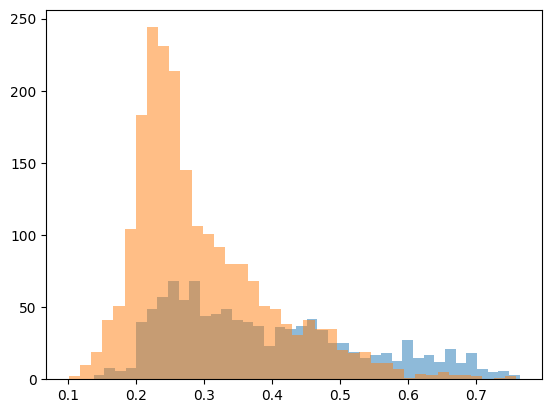

In [1370]:
plt.hist(tf[tf['rush_win'] == 1]['proba'], bins = 40, alpha = 0.5)
plt.hist(tf[tf['rush_win'] == 0]['proba'], bins = 40, alpha = 0.5)

(array([ 5.,  6., 11.,  8., 19., 34., 61., 66., 41., 57., 43., 23., 22.,
        26., 15., 18., 16., 16.,  9., 10.,  9., 11.,  5., 11., 15., 13.,
         8.,  9.,  8.,  5.,  7.,  6.,  4.,  3.,  5.,  1.,  0.,  0.,  2.,
         1.]),
 array([0.12218716, 0.13539478, 0.14860241, 0.16181004, 0.17501767,
        0.1882253 , 0.20143293, 0.21464056, 0.22784819, 0.24105582,
        0.25426346, 0.26747108, 0.28067872, 0.29388633, 0.30709395,
        0.32030159, 0.33350921, 0.34671685, 0.35992447, 0.37313211,
        0.38633972, 0.39954737, 0.41275498, 0.42596263, 0.43917024,
        0.45237789, 0.4655855 , 0.47879314, 0.49200076, 0.50520837,
        0.51841605, 0.53162366, 0.54483128, 0.55803889, 0.57124656,
        0.58445418, 0.59766179, 0.61086941, 0.62407708, 0.6372847 ,
        0.65049231]),
 <BarContainer object of 40 artists>)

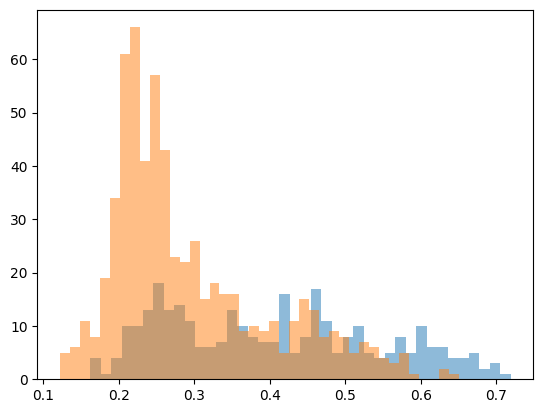

In [1371]:
tf_late = tf[tf['frame_from_overlap'].isin(range(0,5))]
plt.hist(tf_late[tf_late['rush_win'] == 1]['proba'], bins = 40, alpha = 0.5)
plt.hist(tf_late[tf_late['rush_win'] == 0]['proba'], bins = 40, alpha = 0.5)

In [1372]:
af = pro_frames_merge_trunc.copy()
af['proba'] = clf_tuned.predict_proba(af[features3])[:,1]
af['pred'] = np.where(af['proba'] >= .5, 1.0, 0.0)
af['accuracy'] = np.where(af['rush_win'] == af['pred'], 1.0, 0.0)

In [1373]:
by_frame = af.groupby('frame_from_overlap')['proba'].mean().to_frame()
by_frame['proba_if_win'] = af[af['rush_win'] == 1.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['proba_if_loss'] = af[af['rush_win'] == 0.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['proba_diff'] = by_frame['proba_if_win'] - by_frame['proba_if_loss']
by_frame['pred'] = af.groupby('frame_from_overlap')['pred'].mean()
by_frame['accuracy'] = af.groupby('frame_from_overlap')['accuracy'].mean()
by_frame['sensitivity'] = af[af['rush_win'] == 1.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['false_pos_rate'] = af[af['rush_win'] == 0.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['specificity'] = 1 - by_frame['false_pos_rate']
by_frame['precision'] = af[af['pred'] == 1.0].groupby('frame_from_overlap')['rush_win'].mean()
by_frame

,proba,proba_if_win,proba_if_loss,proba_diff,pred,accuracy,sensitivity,false_pos_rate,specificity,precision
frame_from_overlap,,,,,,,,,,
-7,0.292571,0.317426,0.280388,0.037038,0.014349,0.678808,0.033557,0.004934,0.995066,0.769231
-6,0.295551,0.324977,0.281129,0.043848,0.017660,0.684327,0.046980,0.003289,0.996711,0.875000
-5,0.299979,0.334244,0.283184,0.051060,0.019868,0.686534,0.053691,0.003289,0.996711,0.888889
-4,0.303217,0.343535,0.283488,0.060047,0.029768,0.690187,0.073826,0.008210,0.991790,0.814815
-3,0.307092,0.354500,0.283932,0.070568,0.040749,0.697137,0.100671,0.011475,0.988525,0.810811
-2,0.311120,0.367745,0.283457,0.084288,0.061674,0.713656,0.157718,0.014754,0.985246,0.839286
-1,0.315303,0.384575,0.281462,0.103112,0.077093,0.722467,0.194631,0.019672,0.980328,0.828571
0,0.321847,0.405155,0.281148,0.124006,0.096916,0.731278,0.238255,0.027869,0.972131,0.806818
1,0.327706,0.423417,0.280948,0.142469,0.117841,0.745595,0.291946,0.032787,0.967213,0.813084


(array([ 30.,  79., 192., 271., 441., 613., 681., 825., 966., 811., 668.,
        546., 490., 405., 305., 291., 256., 237., 190., 169., 139., 126.,
        104.,  74.,  78.,  71.,  44.,  40.,  39.,  27.,  23.,  26.,  15.,
         15.,  13.,  10.,   2.,   2.,   2.,   2.]),
 array([0.04244881, 0.06299139, 0.08353397, 0.10407655, 0.12461913,
        0.1451617 , 0.1657043 , 0.18624687, 0.20678945, 0.22733203,
        0.2478746 , 0.26841718, 0.28895977, 0.30950236, 0.33004493,
        0.35058752, 0.37113008, 0.39167267, 0.41221526, 0.43275782,
        0.45330042, 0.47384298, 0.49438557, 0.51492816, 0.53547072,
        0.55601329, 0.57655591, 0.59709847, 0.61764103, 0.63818365,
        0.65872622, 0.67926878, 0.6998114 , 0.72035396, 0.74089652,
        0.76143909, 0.78198171, 0.80252427, 0.82306683, 0.84360945,
        0.86415201]),
 <BarContainer object of 40 artists>)

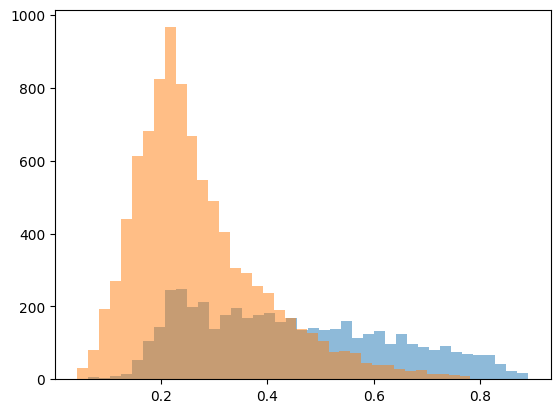

In [1323]:
plt.hist(af[af['rush_win'] == 1]['proba'], bins = 40, alpha = 0.5)
plt.hist(af[af['rush_win'] == 0]['proba'], bins = 40, alpha = 0.5)

In [100]:
likely_losses = af[af['proba'] < 0.3]
likely_wins = af[af['proba'] > 0.6]
pd.set_option('display.max_columns', None)

NameError: name 'af' is not defined

In [1397]:
likely_losses.query('stunt_type == "TT"').groupby(['frame_from_overlap'])[features].mean()

,frame_from_snap,frame_from_overlap,width_in,width_out,depth_in,depth_out,s_in,s_out,a_in,a_out,squareness_in,squareness_out,open_outside_in,open_outside_out,moving_outside_in,moving_outside_out,rotation_in,rotation_out,rotation_outside_in,rotation_outside_out,qb_o_rel_in,qb_o_rel_out,qb_squareness_in,qb_squareness_out,qb_dist_in,qb_dist_out,x_diff,y_diff,dist,min_qb_dist,rel_rotation,penetrator_depth,mean_squareness,dev_squareness,max_squareness,mean_qb_squareness,dev_qb_squareness,max_qb_squareness,exchange
frame_from_overlap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-7,9.487310,-7.0,0.539010,1.547944,1.983706,2.179492,1.829873,1.603350,0.920228,1.271624,21.619721,18.388934,13.172970,-3.885076,101.890228,-42.919289,-1.903020,-3.420609,2.781548,-3.504264,-3.183174,-6.613509,17.914256,30.267903,4.032968,4.144942,1.008934,0.195787,1.188604,3.939853,-4.006929,1.125863,20.004327,15.733654,28.388832,24.091079,19.238720,35.174138,0.697970
-6,10.488189,-6.0,0.572861,1.494803,2.170446,2.333045,1.913701,1.716037,0.923675,1.233780,23.216719,19.915827,13.809895,-7.099659,103.269291,-51.485722,-0.254357,-3.138714,2.286063,-5.330105,-2.343893,-6.823768,19.571138,31.670813,4.063882,4.182565,0.921942,0.162598,1.135542,3.965157,-8.855171,1.398530,21.566273,17.018098,30.903176,25.620976,20.439279,37.407836,0.711286
-5,11.371831,-5.0,0.599239,1.425493,2.341352,2.463099,1.974338,1.804028,0.907099,1.167127,23.570479,21.439239,12.822648,-10.222282,102.616394,-58.085324,-0.653070,-3.477268,2.559268,-8.158620,-2.867578,-6.539758,20.185787,33.428937,4.082048,4.211583,0.826254,0.121746,1.061305,3.980478,-13.524028,1.628310,22.504859,17.776619,32.275775,26.807362,21.345206,38.998558,0.732394
-4,12.297619,-4.0,0.623631,1.358185,2.516161,2.603780,1.979970,1.848571,0.930268,1.098393,23.239077,23.074881,10.845387,-13.054583,88.270387,-67.289375,-0.119911,-3.733512,1.901399,-10.861071,-2.147129,-6.176796,20.424161,35.159859,4.117733,4.255773,0.734554,0.087619,1.021055,4.008839,-18.372708,1.865268,23.156979,18.373112,33.368750,27.792010,22.135939,40.356843,0.735119
-3,13.253125,-3.0,0.658594,1.308875,2.710187,2.760719,1.977750,1.880594,0.985719,1.026625,24.058750,25.043094,10.554937,-14.705906,85.665031,-77.341344,0.809125,-4.467594,3.478812,-13.136594,-1.801388,-7.653826,21.586841,36.546459,4.161429,4.312049,0.650281,0.050531,0.994344,4.049152,-22.484156,2.114250,24.550922,19.388469,35.125906,29.066650,23.032715,41.679115,0.753125
-2,14.179811,-2.0,0.694732,1.262240,2.879085,2.919842,1.984511,1.915741,1.073817,1.009054,25.496656,25.409779,10.924164,-15.590284,77.055804,-90.600757,0.132492,-4.441451,3.322461,-14.658170,-2.755897,-7.653303,22.806331,36.370869,4.204117,4.349372,0.567508,0.040757,0.988901,4.075134,-24.152366,2.336972,25.453218,20.086609,36.373344,29.588600,23.437656,42.465005,0.747634
-1,15.185668,-1.0,0.730098,1.212508,3.088762,3.091889,1.987687,1.917134,1.176189,1.086156,26.530033,25.768534,12.017655,-14.693420,67.303029,-93.747296,-0.201498,-4.074072,2.159870,-14.721564,-2.779934,-7.268447,24.117516,35.603715,4.222872,4.384873,0.482410,0.003127,0.997501,4.088855,-27.540391,2.572215,26.149283,20.597286,37.138567,29.860616,23.628662,42.867863,0.765472
0,16.273038,0.0,0.787509,1.228737,3.347543,3.270034,1.995734,1.887577,1.289932,1.240205,27.941570,25.683106,13.335222,-10.013413,54.035836,-77.578908,-0.403754,-2.474915,2.247235,-12.717099,-3.553814,-6.052329,24.536723,34.319907,4.210189,4.450840,0.441229,-0.077509,0.994544,4.103549,-24.645563,2.828089,26.812338,21.180102,38.246485,29.428315,23.311991,42.413032,0.771331
1,17.307958,1.0,0.793772,1.167751,3.548235,3.463875,1.941073,1.870761,1.362664,1.335225,28.597024,26.394256,13.202422,-7.117855,37.645779,-63.446228,0.644083,-2.244983,1.173979,-11.455709,-2.388923,-6.078804,25.989817,33.654696,4.231685,4.460365,0.373979,-0.084360,1.015609,4.105433,-22.148927,3.067578,27.495640,21.762265,39.450969,29.822257,23.596594,42.806517,0.764706


In [99]:
likely_wins.query('stunt_type == "TT"').groupby('frame_from_overlap')[features].mean()

NameError: name 'likely_wins' is not defined

In [123]:
np.arange(20,101,20)

array([ 20,  40,  60,  80, 100])